# <center>**Análise Exploratória**</center>

O propósito deste notebook é conduzir uma análise exploratória dos dados, buscando compreender quais variáveis têm maior influência na previsão do resultado de lutas em um card completo do UFC.

### Bibliotecas

Importação de todas as bibliotecas utilizadas no projeto.

In [1]:
# Importando Bibliotecas

# Manipulação de dados
import pandas as pd
import numpy as np

# Diretorio
import os

# Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# Regressão Linear
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# Configurações padrões
pd.set_option('display.max_columns', None)

##  `Importando Dataframes`

Realizando a importação dos dataframes que serão utilizados na modelagem.

Para importar os dataframes, primeiramente será necessario realizar uma mudança momentanea no diretorio, para importar e executar o scrip ufc_.

In [3]:
# Alterando o diretorio para a pasta webscraping
os.chdir("../webscaping")

# Importando o scrip ufc.scrap
import ufc_scrap as ufc

# Executando os dataframes
df_events = ufc.get_events()
df_fighters = ufc.get_fighters()
df_fights = ufc.get_fights()

# Retornando ao diretorio atual
os.chdir("../pre_processamento")

df_events

,event_id,event,date,city,state,country
0,EVE0665,UFC Fight Night: Dawson vs. Green,2023-10-07,Las Vegas,Nevada,USA
1,EVE0664,UFC Fight Night: Fiziev vs. Gamrot,2023-09-23,Las Vegas,Nevada,USA
2,EVE0663,UFC Fight Night: Grasso vs. Shevchenko 2,2023-09-16,Las Vegas,Nevada,USA
3,EVE0662,UFC 293: Adesanya vs. Strickland,2023-09-09,Sydney,New South Wales,Australia
4,EVE0661,UFC Fight Night: Gane vs. Spivac,2023-09-02,Paris,Ile-de-France,France
...,...,...,...,...,...,...
660,EVE0005,UFC 6: Clash of the Titans,1995-07-14,Casper,Wyoming,USA
661,EVE0004,UFC 5: The Return of the Beast,1995-04-07,Charlotte,North Carolina,USA
662,EVE0003,UFC 4: Revenge of the Warriors,1994-12-16,Tulsa,Oklahoma,USA
663,EVE0002,UFC 3: The American Dream,1994-09-09,Charlotte,North Carolina,USA


In [4]:
# Visualizando df_fighters
df_fighters

,First,Last,Nickname,Stance,Belt,height,reach,weight,win,lose,draw,total_fights,fighters_id
0,Tom,Aaron,NaN,NaN,NaN,NaN,NaN,70.307,5,3,0,8,FIG3286
1,Danny,Abbadi,The Assassin,Orthodox,NaN,180.34,NaN,70.307,4,6,0,10,FIG2942
2,Nariman,Abbasov,Bayraktar,Orthodox,NaN,172.72,167.64,70.307,28,4,0,32,FIG0482
3,David,Abbott,Tank,Switch,NaN,182.88,NaN,120.202,10,15,0,25,FIG0923
4,Hamdy,Abdelwahab,The Hammer,Southpaw,NaN,187.96,182.88,119.748,5,0,0,5,FIG3664
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4104,Dave,Zitanick,NaN,NaN,NaN,NaN,NaN,77.111,5,7,0,12,FIG2609
4105,Alex,Zuniga,NaN,NaN,NaN,NaN,NaN,65.771,6,3,0,9,FIG3121
4106,George,Zuniga,NaN,NaN,NaN,175.26,NaN,83.915,3,1,0,4,FIG3843
4107,Allan,Zuniga,Tigre,Orthodox,NaN,170.18,177.80,70.307,13,1,0,14,FIG2267


## `Análise de Eventos`

Realizando uma analise dos eventos já realizados pelo UFC.

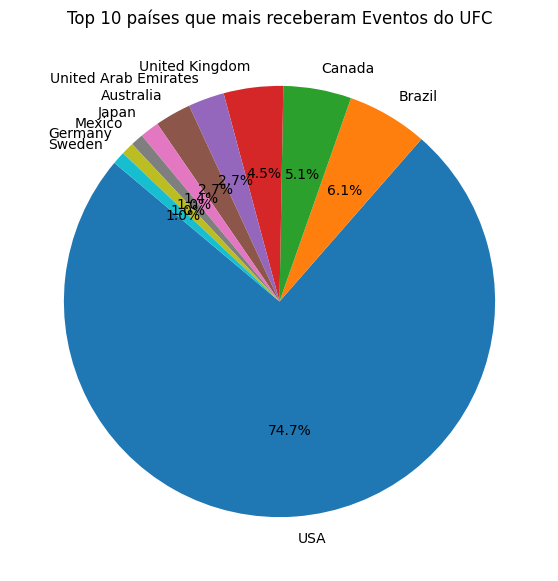

In [5]:
# Países que mais receberam eventos do UFC
df_events['country'].value_counts().head(10)

# Plotando gráfico de pizza
plt.figure(figsize=(7,7))
plt.pie(df_events['country'].value_counts().head(10), labels=df_events['country'].value_counts().head(10).index, autopct='%1.1f%%', startangle=140)

plt.title('Top 10 países que mais receberam Eventos do UFC')


plt.show()

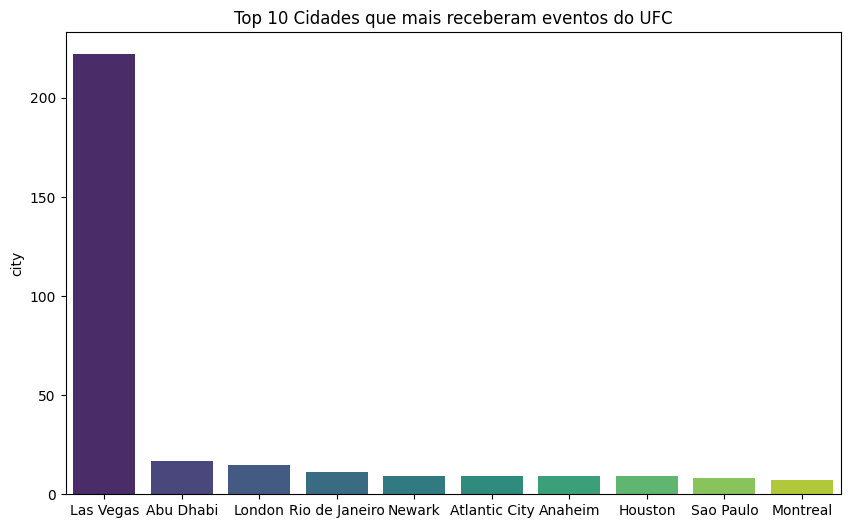

In [6]:
# Cidades com mais eventos
plt.figure(figsize=(10,6))
sns.barplot(x=df_events['city'].value_counts().head(10).index, y=df_events['city'].value_counts().head(10), palette='viridis')
plt.title('Top 10 Cidades que mais receberam eventos do UFC')
plt.show()

In [7]:
df_events['city'].value_counts().head(10)

Las Vegas         222
Abu Dhabi          17
London             15
Rio de Janeiro     11
Newark              9
Atlantic City       9
Anaheim             9
Houston             9
Sao Paulo           8
Montreal            7
Name: city, dtype: int64

A principio nenhuma informação contida na tabela de evetos será utilizada no dataframe final.

## `Pré-Processamento`

A princio será utilizada duas abordagens diferentes para tentar predizer o resultado das lutas do UFC. 

- **Abordagem 1**:
A primeria estratégia colocará ambos os lutadores na mesma linha, e o modelo tentará prever se o lutador 1, o lutador 2 ou nenhum deles sairá vitorioso. Essa abordagem requer menos manipulações no dataframe e processa os dados de forma mais direta.

- **Abordagem 2**:
A segunda abordagem buscará prever a probabilidade de vitória para cada um dos lutadores. Em outras palavras, cada lutador estará representado em uma linha distinta, e o modelo tentará prever se ele irá vencer, perder, empatar ou obter um resultado "no contest", com base em variáveis comparativas, como a diferença de altura e alcance. Essa abordagem tende a enfatizar a interpretação das variáveis preditoras e seu impacto no desfecho da luta.




### **Abordagem 1**

Essa abordagem se alinha mais com a atual configuração dos dataframes, exigindo menos ajustes para se obter o dataframe final.

Primeiro, será preciso fazer algumas correções no df_fights, que servirá como base para o df_abordagem1, alimentando assim o modelo de classificação. O resultado previsto por esse modelo será: 1 (se o lutador 1 venceu), 2 (se o lutador 2 venceu) ou 3 (se nenhum dos dois venceu). Para atingir isso, algumas modificações e processamentos serão necessários na base de dados.

In [8]:
df_abordagem1 = df_fights[["event_id", "fight_id","weight_class", "w/l", "fighter1", "fighter2", "method"]]

df_abordagem1

,event_id,fight_id,weight_class,w/l,fighter1,fighter2,method
0,EVE0663,F066301,Women's Flyweight,draw,Alexa Grasso,Valentina Shevchenko,S-DEC
1,EVE0663,F066302,Welterweight,win,Jack Della Maddalena,Kevin Holland,S-DEC
2,EVE0663,F066303,Bantamweight,win,Raul Rosas Jr.,Terrence Mitchell,KO/TKO_Punches
3,EVE0663,F066304,Lightweight,win,Daniel Zellhuber,Christos Giagos,SUB_Anaconda_Choke
4,EVE0663,F066305,Featherweight,win,Kyle Nelson,Fernando Padilla,U-DEC
...,...,...,...,...,...,...,...
7335,EVE0001,F000111,Open Weight,win,Orlando Wiet,Robert Lucarelli,KO/TKO
7336,EVE0001,F000112,Open Weight,win,Frank Hamaker,Thaddeus Luster,SUB_Keylock
7337,EVE0001,F000113,Open Weight,win,Johnny Rhodes,David Levicki,KO/TKO_Punches
7338,EVE0001,F000114,Open Weight,win,Patrick Smith,Ray Wizard,SUB_Guillotine_Choke


Primeiro, vamos tratar as strings nas colunas 'fighter1' e 'fighter2', removendo espaços no início e no final de cada nome. Isso facilitará a realização do left join usando o código de cada lutador.

In [9]:
# Retirando espaços da coluna fighter1
df_abordagem1["fighter1"] = df_abordagem1["fighter1"].str.strip()

# Retirando espaços da coluna fighter2
df_abordagem1["fighter2"] = df_abordagem1["fighter2"].str.strip()

C:\Users\GBinfo\AppData\Local\Temp\ipykernel_7904\1119377754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abordagem1["fighter1"] = df_abordagem1["fighter1"].str.strip()
C:\Users\GBinfo\AppData\Local\Temp\ipykernel_7904\1119377754.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abordagem1["fighter2"] = df_abordagem1["fighter2"].str.strip()


Realizando left join para obter os fighters_id.

In [10]:
# Adicionando código do primeiro lutador
df_fighters["Fullname"] = df_fighters["First"] + " " + df_fighters["Last"]
# Ajustando Fullname para lutadores que possuem o First nulo
df_fighters.loc[df_fighters["First"].isna(), "Fullname"] = df_fighters["Last"]
# Ajustando para os lutadores que só possuem o First
df_fighters.loc[df_fighters["Last"].isna(), "Fullname"] = df_fighters["First"]

df_abordagem1 = df_abordagem1.merge(df_fighters[["Fullname", "fighters_id"]], left_on="fighter1", right_on="Fullname", how="left")

df_abordagem1 = df_abordagem1.rename(columns={"fighters_id":"fighters1_id"})

df_abordagem1 = df_abordagem1.drop(columns=["Fullname"])

# Adicionando código do segundo lutador
df_abordagem1 = df_abordagem1.merge(df_fighters[["Fullname", "fighters_id"]], left_on="fighter2", right_on="Fullname", how="left")

df_abordagem1 = df_abordagem1.rename(columns={"fighters_id":"fighters2_id"})

df_abordagem1 = df_abordagem1.drop(columns=["Fullname"])

df_abordagem1

,event_id,fight_id,weight_class,w/l,fighter1,fighter2,method,fighters1_id,fighters2_id
0,EVE0663,F066301,Women's Flyweight,draw,Alexa Grasso,Valentina Shevchenko,S-DEC,FIG1586,FIG0827
1,EVE0663,F066302,Welterweight,win,Jack Della Maddalena,Kevin Holland,S-DEC,FIG1911,FIG0408
2,EVE0663,F066303,Bantamweight,win,Raul Rosas Jr.,Terrence Mitchell,KO/TKO_Punches,FIG3312,FIG1830
3,EVE0663,F066304,Lightweight,win,Daniel Zellhuber,Christos Giagos,SUB_Anaconda_Choke,FIG2320,FIG0614
4,EVE0663,F066305,Featherweight,win,Kyle Nelson,Fernando Padilla,U-DEC,FIG1431,FIG1609
...,...,...,...,...,...,...,...,...,...
7363,EVE0001,F000111,Open Weight,win,Orlando Wiet,Robert Lucarelli,KO/TKO,FIG3607,FIG4000
7364,EVE0001,F000112,Open Weight,win,Frank Hamaker,Thaddeus Luster,SUB_Keylock,FIG4059,FIG4006
7365,EVE0001,F000113,Open Weight,win,Johnny Rhodes,David Levicki,KO/TKO_Punches,FIG3858,FIG3850
7366,EVE0001,F000114,Open Weight,win,Patrick Smith,Ray Wizard,SUB_Guillotine_Choke,FIG0308,FIG4021


In [11]:
df_abordagem1["fight_id"].value_counts().index

Index(['F047510', 'F020104', 'F053513', 'F059606', 'F062105', 'F063812',
       'F018907', 'F056605', 'F025502', 'F051211',
       ...
       'F045702', 'F045701', 'F045813', 'F045812', 'F045811', 'F045810',
       'F045809', 'F045808', 'F045807', 'F000115'],
      dtype='object', length=7340)

In [12]:
df_abordagem1[df_abordagem1["fight_id"] == "F047510"]

,event_id,fight_id,weight_class,w/l,fighter1,fighter2,method,fighters1_id,fighters2_id
2259,EVE0475,F047510,Lightweight,win,Gilbert Burns,Mike Davis,SUB_Rear_Naked_Choke,FIG0695,FIG3926
2260,EVE0475,F047510,Lightweight,win,Gilbert Burns,Mike Davis,SUB_Rear_Naked_Choke,FIG0695,FIG2589


Verificando se temos valores de código nulos:

In [13]:
# Para os lutadores 1
null_fighter1_id = df_abordagem1[df_abordagem1["fighters1_id"].isna()].shape[0]
print(f"Valores de fighters1_id zerados: {null_fighter1_id}")

# Para os lutadores 2
null_fighter2_id = df_abordagem1[df_abordagem1["fighters2_id"].isna()].shape[0]
print(f"Valores de fighters2_id zerados: {null_fighter2_id}")

Valores de fighters1_id zerados: 0
Valores de fighters2_id zerados: 0


Abaixo estão as preditoras que serão utilizadas na modelagem e seus respectivos tratamentos.

#### ***Stance***

Adicionando coluna stance dos lutadores ao dataframe.

In [14]:
# Para o lutador 1
df_abordagem1 = df_abordagem1.merge(df_fighters[["fighters_id", "Stance"]], right_on="fighters_id", left_on="fighters1_id", how="left")
df_abordagem1 = df_abordagem1.rename(columns={"Stance": "stance1"})
df_abordagem1 = df_abordagem1.drop(columns=["fighters_id"])

# Para o lutador 2
df_abordagem1 = df_abordagem1.merge(df_fighters[["fighters_id", "Stance"]], right_on="fighters_id", left_on="fighters2_id", how="left")
df_abordagem1 = df_abordagem1.rename(columns={"Stance": "stance2"})
df_abordagem1 = df_abordagem1.drop(columns=["fighters_id"])

df_abordagem1

,event_id,fight_id,weight_class,w/l,fighter1,fighter2,method,fighters1_id,fighters2_id,stance1,stance2
0,EVE0663,F066301,Women's Flyweight,draw,Alexa Grasso,Valentina Shevchenko,S-DEC,FIG1586,FIG0827,Orthodox,Southpaw
1,EVE0663,F066302,Welterweight,win,Jack Della Maddalena,Kevin Holland,S-DEC,FIG1911,FIG0408,Switch,Orthodox
2,EVE0663,F066303,Bantamweight,win,Raul Rosas Jr.,Terrence Mitchell,KO/TKO_Punches,FIG3312,FIG1830,Switch,Orthodox
3,EVE0663,F066304,Lightweight,win,Daniel Zellhuber,Christos Giagos,SUB_Anaconda_Choke,FIG2320,FIG0614,Switch,Orthodox
4,EVE0663,F066305,Featherweight,win,Kyle Nelson,Fernando Padilla,U-DEC,FIG1431,FIG1609,Switch,Orthodox
...,...,...,...,...,...,...,...,...,...,...,...
7363,EVE0001,F000111,Open Weight,win,Orlando Wiet,Robert Lucarelli,KO/TKO,FIG3607,FIG4000,Southpaw,NaN
7364,EVE0001,F000112,Open Weight,win,Frank Hamaker,Thaddeus Luster,SUB_Keylock,FIG4059,FIG4006,NaN,NaN
7365,EVE0001,F000113,Open Weight,win,Johnny Rhodes,David Levicki,KO/TKO_Punches,FIG3858,FIG3850,Orthodox,NaN
7366,EVE0001,F000114,Open Weight,win,Patrick Smith,Ray Wizard,SUB_Guillotine_Choke,FIG0308,FIG4021,Orthodox,NaN


Analisando a quantidade de lutadores que não possuem stance na base de dados final que será utilizada na modelagem

In [15]:
# Lutador 1
print("Frequência absoluta de Lutadores1 com Stace nulo:")
print(df_abordagem1[df_abordagem1["stance1"].isna()].drop_duplicates("fighters1_id").shape[0])

# Lutador 2
print("Frequência absoluta de Lutadores2 com Stace nulo:")
print(df_abordagem1[df_abordagem1["stance2"].isna()].drop_duplicates("fighters2_id").shape[0])

Frequência absoluta de Lutadores1 com Stace nulo:
19
Frequência absoluta de Lutadores2 com Stace nulo:
80


In [16]:
# Em Frequencia Relativa
# Total de Lutadores
# Lutador 1
print("Frequência Relativa de Lutadores1 com Stace nulo:")
print(df_abordagem1[df_abordagem1["stance1"].isna()].drop_duplicates("fighters1_id").shape[0]/df_abordagem1["fighters1_id"].drop_duplicates().shape[0])

# Lutador 2
print("Frequência Relativa de Lutadores2 com Stace nulo:")
print(df_abordagem1[df_abordagem1["stance2"].isna()].drop_duplicates("fighters2_id").shape[0]/df_abordagem1["fighters2_id"].drop_duplicates().shape[0])

Frequência Relativa de Lutadores1 com Stace nulo:
0.011183048852266038
Frequência Relativa de Lutadores2 com Stace nulo:
0.03473729917498915


Analisando a proporção dos dados de Stance

In [17]:
# Para os Lutadores 1
df_abordagem1.drop_duplicates("fighters1_id").value_counts("stance1")

stance1
Orthodox       1285
Southpaw        299
Switch           93
Open Stance       2
Sideways          1
dtype: int64

In [18]:
# Para os Lutadores 2
df_abordagem1.drop_duplicates("fighters2_id").value_counts("stance2") 

stance2
Orthodox       1709
Southpaw        384
Switch          121
Open Stance       6
Sideways          3
dtype: int64

In [19]:
# Observando proporção global
df_fighters["Stance"].value_counts()

Orthodox       2492
Southpaw        557
Switch          186
Open Stance       7
Sideways          3
Name: Stance, dtype: int64

Como é uma porcentagem pequena de lutadores com Stance nulos, iremos considerar estes valores nulos como Orthodox.

In [20]:
# Computando stances nulos como Orthodox
# Lutadores 1 
df_abordagem1.loc[df_abordagem1["stance1"].isna(), "stance1"] = "Orthodox"

# Lutadores 2
df_abordagem1.loc[df_abordagem1["stance2"].isna(), "stance2"] = "Orthodox"


Visualizando mudanças:

In [21]:
# Lutador 1
print("Quantidade de Lutadores1 com Stace nulo:")
print(df_abordagem1[df_abordagem1["stance1"].isna()].drop_duplicates("fighters1_id").shape[0])

# Lutador 2
print("Quantidade de Lutadores2 com Stace nulo:")
print(df_abordagem1[df_abordagem1["stance2"].isna()].drop_duplicates("fighters2_id").shape[0])

Quantidade de Lutadores1 com Stace nulo:
0
Quantidade de Lutadores2 com Stace nulo:
0


#### ***Height***

Primeiramente iremos realizar o merge para ambos os lutadores.

In [22]:
# Para o lutador 1
df_abordagem1 = df_abordagem1.merge(df_fighters[["fighters_id", "height"]], right_on="fighters_id", left_on="fighters1_id", how="left")
df_abordagem1 = df_abordagem1.rename(columns={"height": "height1"})
df_abordagem1 = df_abordagem1.drop(columns=["fighters_id"])

# Para o lutador 2
df_abordagem1 = df_abordagem1.merge(df_fighters[["fighters_id", "height"]], right_on="fighters_id", left_on="fighters2_id", how="left")
df_abordagem1 = df_abordagem1.rename(columns={"height": "height2"})
df_abordagem1 = df_abordagem1.drop(columns=["fighters_id"])

df_abordagem1

,event_id,fight_id,weight_class,w/l,fighter1,fighter2,method,fighters1_id,fighters2_id,stance1,stance2,height1,height2
0,EVE0663,F066301,Women's Flyweight,draw,Alexa Grasso,Valentina Shevchenko,S-DEC,FIG1586,FIG0827,Orthodox,Southpaw,165.10,165.10
1,EVE0663,F066302,Welterweight,win,Jack Della Maddalena,Kevin Holland,S-DEC,FIG1911,FIG0408,Switch,Orthodox,180.34,190.50
2,EVE0663,F066303,Bantamweight,win,Raul Rosas Jr.,Terrence Mitchell,KO/TKO_Punches,FIG3312,FIG1830,Switch,Orthodox,175.26,177.80
3,EVE0663,F066304,Lightweight,win,Daniel Zellhuber,Christos Giagos,SUB_Anaconda_Choke,FIG2320,FIG0614,Switch,Orthodox,185.42,177.80
4,EVE0663,F066305,Featherweight,win,Kyle Nelson,Fernando Padilla,U-DEC,FIG1431,FIG1609,Switch,Orthodox,180.34,185.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7363,EVE0001,F000111,Open Weight,win,Orlando Wiet,Robert Lucarelli,KO/TKO,FIG3607,FIG4000,Southpaw,Orthodox,177.80,187.96
7364,EVE0001,F000112,Open Weight,win,Frank Hamaker,Thaddeus Luster,SUB_Keylock,FIG4059,FIG4006,Orthodox,Orthodox,NaN,190.50
7365,EVE0001,F000113,Open Weight,win,Johnny Rhodes,David Levicki,KO/TKO_Punches,FIG3858,FIG3850,Orthodox,Orthodox,182.88,195.58
7366,EVE0001,F000114,Open Weight,win,Patrick Smith,Ray Wizard,SUB_Guillotine_Choke,FIG0308,FIG4021,Orthodox,Orthodox,187.96,NaN


Analisando os valores nulos para os dois lutadores.

In [23]:
# Lutador 1
print("Frequência absoluta de lutadores1 com height nulo:")
print(df_abordagem1[df_abordagem1["height1"].isna()].drop_duplicates("fighters1_id").shape[0])

# Lutador 2
print("Frequência absoluta de lutadores2 com height nulo:")
print(df_abordagem1[df_abordagem1["height2"].isna()].drop_duplicates("fighters2_id").shape[0])

Frequência absoluta de lutadores1 com height nulo:
5
Frequência absoluta de lutadores2 com height nulo:
19


In [24]:
# Em Frequencia Relativa
# Total de Lutadores
# Lutador 1
print("Frequência Relativa de Lutadores1 com Stace nulo:")
print(df_abordagem1[df_abordagem1["height1"].isna()].drop_duplicates("fighters1_id").shape[0]/df_abordagem1["fighters1_id"].drop_duplicates().shape[0])

# Lutador 2
print("Frequência Relativa de Lutadores2 com Stace nulo:")
print(df_abordagem1[df_abordagem1["height2"].isna()].drop_duplicates("fighters2_id").shape[0]/df_abordagem1["fighters2_id"].drop_duplicates().shape[0])

Frequência Relativa de Lutadores1 com Stace nulo:
0.002942907592701589
Frequência Relativa de Lutadores2 com Stace nulo:
0.008250108554059922


Como podemos perceber, existe apenas uma pequena porcentagem de lutadores com height nulos. Para predizer de maneira mais aproximada destas alturas iremos considerar a altura da classe de peso, variavel weight_class.

Analisando as distribuições de altura através da classe de peso.

In [25]:
# Função que retorna a moda
def calc_moda(x):
    moda = x.mode()
    if moda.empty:
        return None
    else:
        return moda.iloc[0]

# Criando tabela para Analise de altura
height_analise = df_abordagem1.groupby("weight_class")[["height1", "height2"]].agg([calc_moda ,"mean", "std"])


height_analise

height1                         height2              \
                      calc_moda        mean       std calc_moda        mean   
weight_class                                                                  
Bantamweight             167.64  170.752000  4.500933    170.18  170.664000   
Catch Weight             172.72  176.872698  7.892369    167.64  177.114603   
Featherweight            172.72  175.038657  5.175117    172.72  174.806429   
Flyweight                165.10  166.516538  4.638044    165.10  167.070128   
Heavyweight              190.50  190.115830  5.972275    190.50  189.662062   
Light Heavyweight        187.96  187.859482  4.227229    190.50  187.046220   
Lightweight              177.80  176.802357  4.810048    177.80  176.820771   
Middleweight             185.42  184.582808  4.568786    185.42  184.085336   
Open Weight              185.42  185.726552  5.297910    182.88  185.060566   
Super Heavyweight        190.50  190.500000       NaN    208.28  208.280000   
Welterweight             180.34  181.356820  4.649042    182.88  180.916061   
Women's Bantamweight     167.64  169.508042  4.355400    167.64  168.567302   
Women's Featherweight    172.72  171.756552  6.199956    170.18  171.844138   
Women's Flyweight        165.10  166.485455  3.873853    167.64  166.558373   
Women's Strawweight      160.02  161.707153  4.511091    160.02  162.013066   

                                 
                            std  
weight_class                     
Bantamweight           4.540490  
Catch Weight           8.389648  
Featherweight          4.897466  
Flyweight              4.355085  
Heavyweight            6.208003  
Light Heavyweight      4.531858  
Lightweight            4.927250  
Middleweight           4.883878  
Open Weight            7.611437  
Super Heavyweight           NaN  
Welterweight           4.678001  
Women's Bantamweight   4.663738  
Women's Featherweight  5.182199  
Women's Flyweight      4.066367  
Women's Strawweight    4.673668

Percebe-se que existe uma distinção clara de altura por catagoria de peso. Os valores nulos serão substituidos de acordo com a moda de cada categoria.

In [26]:
# Lutador 1
# Lista de index com heights1 zeradas
index_list = df_abordagem1[df_abordagem1["height1"].isna()].index.to_list()

#Lista de index dos heights com valores nulos para o lutador 1
df_abordagem1["height1"] = df_abordagem1.apply(lambda x: height_analise["height1"]["calc_moda"][x["weight_class"]] if np.isnan(x["height1"]) else x["height1"], axis=1)

# Visualizando mudanças
df_abordagem1[df_abordagem1.index.isin(index_list)] 

,event_id,fight_id,weight_class,w/l,fighter1,fighter2,method,fighters1_id,fighters2_id,stance1,stance2,height1,height2
519,EVE0621,F062105,Lightweight,win,Mike Davis,Viacheslav Borshchev,U-DEC,FIG3926,FIG3014,Orthodox,Orthodox,177.80,180.34
1421,EVE0547,F054712,Lightweight,win,Mike Davis,Mason Jones,U-DEC,FIG3926,FIG2521,Orthodox,Orthodox,177.80,177.80
1999,EVE0496,F049608,Lightweight,win,Mike Davis,Thomas Gifford,KO/TKO_Punch,FIG3926,FIG1135,Orthodox,Orthodox,177.80,185.42
7194,EVE0020,F002007,Middleweight,win,Tulio Palhares,Adriano Santos,KO/TKO_Punches,FIG1636,FIG4041,Orthodox,Orthodox,185.42,NaN
7195,EVE0020,F002008,Lightweight,win,Cesar Marscucci,Paulo Santos,KO/TKO,FIG3724,FIG3863,Orthodox,Orthodox,177.80,NaN
7243,EVE0014,F001408,Lightweight,win,Jack Nilson,Saeed Hosseini,KO/TKO_Elbows,FIG3382,FIG4049,Orthodox,Orthodox,177.80,NaN
7364,EVE0001,F000112,Open Weight,win,Frank Hamaker,Thaddeus Luster,SUB_Keylock,FIG4059,FIG4006,Orthodox,Orthodox,185.42,190.50


In [27]:
# Lutador 2
# Lista de index com heights1 zeradas
index_list = df_abordagem1[df_abordagem1["height2"].isna()].index.to_list()

#Lista de index dos heights com valores nulos para o lutador 1
df_abordagem1["height2"] = df_abordagem1.apply(lambda x: height_analise["height2"]["calc_moda"][x["weight_class"]] if np.isnan(x["height2"]) else x["height2"], axis=1)

# Visualizando mudanças
df_abordagem1[df_abordagem1.index.isin(index_list)] 

,event_id,fight_id,weight_class,w/l,fighter1,fighter2,method,fighters1_id,fighters2_id,stance1,stance2,height1,height2
2259,EVE0475,F047510,Lightweight,win,Gilbert Burns,Mike Davis,SUB_Rear_Naked_Choke,FIG0695,FIG3926,Orthodox,Orthodox,177.80,177.80
5606,EVE0187,F018705,Lightweight,win,Terry Etim,Edward Faaloloto,SUB_Guillotine_Choke,FIG1315,FIG3468,Orthodox,Orthodox,185.42,177.80
5722,EVE0177,F017711,Lightweight,win,Michael Johnson,Edward Faaloloto,KO/TKO_Punches,FIG0229,FIG3468,Southpaw,Orthodox,177.80,177.80
5813,EVE0169,F016909,Light Heavyweight,win,Anthony Perosh,Tom Blackledge,SUB_Rear_Naked_Choke,FIG0956,FIG1902,Orthodox,Orthodox,190.50,190.50
7187,EVE0021,F002107,Lightweight,win,Laverne Clark,Frank Caracci,KO/TKO_Punches,FIG0103,FIG3745,Orthodox,Orthodox,180.34,177.80
7194,EVE0020,F002007,Middleweight,win,Tulio Palhares,Adriano Santos,KO/TKO_Punches,FIG1636,FIG4041,Orthodox,Orthodox,185.42,185.42
7195,EVE0020,F002008,Lightweight,win,Cesar Marscucci,Paulo Santos,KO/TKO,FIG3724,FIG3863,Orthodox,Orthodox,177.80,177.80
7204,EVE0019,F001909,Middleweight,win,Chuck Liddell,Noe Hernandez,U-DEC,FIG0640,FIG3056,Orthodox,Orthodox,187.96,185.42
7234,EVE0015,F001508,Heavyweight,win,Alex Hunter,Sam Fulton,SUB_Other,FIG3961,FIG3929,Orthodox,Orthodox,175.26,190.50
7243,EVE0014,F001408,Lightweight,win,Jack Nilson,Saeed Hosseini,KO/TKO_Elbows,FIG3382,FIG4049,Orthodox,Orthodox,177.80,177.80


#### ***Weight***

Tratamentos da preditora chamada weight.

In [28]:
# Para o lutador 1
df_abordagem1 = df_abordagem1.merge(df_fighters[["fighters_id", "weight"]], right_on="fighters_id", left_on="fighters1_id", how="left")
df_abordagem1 = df_abordagem1.rename(columns={"weight": "weight1"})
df_abordagem1 = df_abordagem1.drop(columns=["fighters_id"])

# Para o lutador 2
df_abordagem1 = df_abordagem1.merge(df_fighters[["fighters_id", "weight"]], right_on="fighters_id", left_on="fighters2_id", how="left")
df_abordagem1 = df_abordagem1.rename(columns={"weight": "weight2"})
df_abordagem1 = df_abordagem1.drop(columns=["fighters_id"])

df_abordagem1

,event_id,fight_id,weight_class,w/l,fighter1,fighter2,method,fighters1_id,fighters2_id,stance1,stance2,height1,height2,weight1,weight2
0,EVE0663,F066301,Women's Flyweight,draw,Alexa Grasso,Valentina Shevchenko,S-DEC,FIG1586,FIG0827,Orthodox,Southpaw,165.10,165.10,56.699,56.699
1,EVE0663,F066302,Welterweight,win,Jack Della Maddalena,Kevin Holland,S-DEC,FIG1911,FIG0408,Switch,Orthodox,180.34,190.50,77.111,77.111
2,EVE0663,F066303,Bantamweight,win,Raul Rosas Jr.,Terrence Mitchell,KO/TKO_Punches,FIG3312,FIG1830,Switch,Orthodox,175.26,177.80,61.235,61.235
3,EVE0663,F066304,Lightweight,win,Daniel Zellhuber,Christos Giagos,SUB_Anaconda_Choke,FIG2320,FIG0614,Switch,Orthodox,185.42,177.80,70.307,70.307
4,EVE0663,F066305,Featherweight,win,Kyle Nelson,Fernando Padilla,U-DEC,FIG1431,FIG1609,Switch,Orthodox,180.34,185.42,65.771,65.771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7363,EVE0001,F000111,Open Weight,win,Orlando Wiet,Robert Lucarelli,KO/TKO,FIG3607,FIG4000,Southpaw,Orthodox,177.80,187.96,77.111,111.130
7364,EVE0001,F000112,Open Weight,win,Frank Hamaker,Thaddeus Luster,SUB_Keylock,FIG4059,FIG4006,Orthodox,Orthodox,185.42,190.50,NaN,95.254
7365,EVE0001,F000113,Open Weight,win,Johnny Rhodes,David Levicki,KO/TKO_Punches,FIG3858,FIG3850,Orthodox,Orthodox,182.88,195.58,95.254,124.738
7366,EVE0001,F000114,Open Weight,win,Patrick Smith,Ray Wizard,SUB_Guillotine_Choke,FIG0308,FIG4021,Orthodox,Orthodox,187.96,182.88,102.058,NaN


Como os lutadores a principio lutam com o mesmo peso, iremos analisar se existe esta diferença no dataframe.

In [29]:
# Primeiro retirando os valores nulos
weight_analise = df_abordagem1.copy()
weight_analise = weight_analise[~weight_analise["weight1"].isna()]
weight_analise = weight_analise[~weight_analise["weight2"].isna()]

# Analisando colunas em que os pesos se diferem
weight_analise = weight_analise[weight_analise["weight1"] != weight_analise["weight2"]]

# Verificando categoria de peso
weight_analise["weight_class"].value_counts()

Heavyweight              621
Lightweight              413
Middleweight             371
Welterweight             309
Featherweight            256
Light Heavyweight        247
Bantamweight             146
Open Weight              101
Women's Bantamweight      72
Flyweight                 70
Women's Strawweight       69
Women's Flyweight         59
Catch Weight              21
Women's Featherweight     16
Super Heavyweight          1
Name: weight_class, dtype: int64

Existem inconsistências na variável preditora relacionada ao peso dos atletas na tabela "fighters". A principio esta variável representa o peso do atleta em sua última luta. No entanto, há lutadores que competem em diferentes categorias de peso, o que pode comprometer a precisão desta variável. Idealmente, apenas algumas categorias deveriam permitir grandes variações de peso entre os atletas. Contudo, devido a essa dificuldade de categorização, outras classes estão exibindo tais discrepâncias. Para a modelagem inicial, utilizaremos os pesos conforme estão, mas é crucial revisar e refinar essa coluna em modelagens futuras.

In [30]:
# Lutador 1
print("Frequência absoluta de lutadores1 com weight nulo:")
print(df_abordagem1[df_abordagem1["weight1"].isna()].drop_duplicates("fighters1_id").shape[0])

# Lutador 2
print("Frequência absoluta de lutadores2 com weight nulo:")
print(df_abordagem1[df_abordagem1["weight2"].isna()].drop_duplicates("fighters2_id").shape[0])

Frequência absoluta de lutadores1 com weight nulo:
4
Frequência absoluta de lutadores2 com weight nulo:
17


In [31]:
# Em Frequencia Relativa
# Total de Lutadores
# Lutador 1
print("Frequência Relativa de Lutadores1 com weight nulo:")
print(df_abordagem1[df_abordagem1["weight1"].isna()].drop_duplicates("fighters1_id").shape[0]/df_abordagem1["fighters1_id"].drop_duplicates().shape[0])

# Lutador 2
print("Frequência Relativa de Lutadores2 com weight nulo:")
print(df_abordagem1[df_abordagem1["weight2"].isna()].drop_duplicates("fighters2_id").shape[0]/df_abordagem1["fighters2_id"].drop_duplicates().shape[0])

Frequência Relativa de Lutadores1 com weight nulo:
0.002354326074161271
Frequência Relativa de Lutadores2 com weight nulo:
0.007381676074685193


O tratamento para variáveis com valores nulos será feito usando a métrica da moda, baseada na categoria de peso, similarmente ao que foi feito com a altura.

In [32]:
# Função que retorna a moda
def calc_moda(x):
    moda = x.mode()
    if moda.empty:
        return None
    else:
        return moda.iloc[0]

# Criando tabela para Analise de altura
weight_analise = df_abordagem1.groupby("weight_class")[["weight1", "weight2"]].agg([calc_moda ,"mean", "std"])


weight_analise

weight1                          weight2              \
                      calc_moda        mean        std calc_moda        mean   
weight_class                                                                   
Bantamweight             61.235   61.592156   3.474769    61.235   61.413578   
Catch Weight             61.235   70.630937  11.191514    61.235   70.810889   
Featherweight            65.771   65.874680   2.346989    65.771   65.819600   
Flyweight                56.699   57.498615   2.991913    56.699   57.382308   
Heavyweight             120.202  111.844706   9.292175   120.202  111.445985   
Light Heavyweight        92.986   92.716218   5.781639    92.986   91.864954   
Lightweight              70.307   70.736364   3.492626    70.307   70.490500   
Middleweight             83.915   83.704704   4.139017    83.915   83.726447   
Open Weight              92.986  101.381647  14.981840   104.326  106.632566   
Super Heavyweight       113.398  113.398000        NaN   120.202  120.202000   
Welterweight             77.111   77.265851   2.988356    77.111   76.925013   
Women's Bantamweight     61.235   60.755000   2.289220    61.235   60.107000   
Women's Featherweight    65.771   64.050448   2.546918    61.235   63.268379   
Women's Flyweight        56.699   56.460263   1.616652    56.699   56.416856   
Women's Strawweight      52.163   52.858299   1.637137    52.163   52.742416   

                                  
                             std  
weight_class                      
Bantamweight            2.915980  
Catch Weight           11.321067  
Featherweight           2.280423  
Flyweight               2.571099  
Heavyweight             9.321457  
Light Heavyweight       4.877475  
Lightweight             3.073656  
Middleweight            4.303138  
Open Weight            30.559412  
Super Heavyweight            NaN  
Welterweight            2.784647  
Women's Bantamweight    2.504480  
Women's Featherweight   2.596186  
Women's Flyweight       1.993921  
Women's Strawweight     1.516874

Aplicando o tratamento:

In [33]:
# Lutador 1
# Lista de index com heights1 zeradas
index_list = df_abordagem1[df_abordagem1["weight1"].isna()].index.to_list()

#Lista de index dos heights com valores nulos para o lutador 1
df_abordagem1["weight1"] = df_abordagem1.apply(lambda x: weight_analise["weight1"]["calc_moda"][x["weight_class"]] if np.isnan(x["weight1"]) else x["weight1"], axis=1)

# Visualizando mudanças
df_abordagem1[df_abordagem1.index.isin(index_list)] 

,event_id,fight_id,weight_class,w/l,fighter1,fighter2,method,fighters1_id,fighters2_id,stance1,stance2,height1,height2,weight1,weight2
519,EVE0621,F062105,Lightweight,win,Mike Davis,Viacheslav Borshchev,U-DEC,FIG3926,FIG3014,Orthodox,Orthodox,177.80,180.34,70.307,70.307
1421,EVE0547,F054712,Lightweight,win,Mike Davis,Mason Jones,U-DEC,FIG3926,FIG2521,Orthodox,Orthodox,177.80,177.80,70.307,70.307
1999,EVE0496,F049608,Lightweight,win,Mike Davis,Thomas Gifford,KO/TKO_Punch,FIG3926,FIG1135,Orthodox,Orthodox,177.80,185.42,70.307,70.307
7195,EVE0020,F002008,Lightweight,win,Cesar Marscucci,Paulo Santos,KO/TKO,FIG3724,FIG3863,Orthodox,Orthodox,177.80,177.80,70.307,NaN
7243,EVE0014,F001408,Lightweight,win,Jack Nilson,Saeed Hosseini,KO/TKO_Elbows,FIG3382,FIG4049,Orthodox,Orthodox,177.80,177.80,70.307,NaN
7364,EVE0001,F000112,Open Weight,win,Frank Hamaker,Thaddeus Luster,SUB_Keylock,FIG4059,FIG4006,Orthodox,Orthodox,185.42,190.50,92.986,95.254


In [34]:
# Lutador 2
# Lista de index com heights1 zeradas
index_list = df_abordagem1[df_abordagem1["weight2"].isna()].index.to_list()

#Lista de index dos heights com valores nulos para o lutador 1
df_abordagem1["weight2"] = df_abordagem1.apply(lambda x: weight_analise["weight2"]["calc_moda"][x["weight_class"]] if np.isnan(x["weight2"]) else x["weight2"], axis=1)

# Visualizando mudanças
df_abordagem1[df_abordagem1.index.isin(index_list)] 

,event_id,fight_id,weight_class,w/l,fighter1,fighter2,method,fighters1_id,fighters2_id,stance1,stance2,height1,height2,weight1,weight2
2259,EVE0475,F047510,Lightweight,win,Gilbert Burns,Mike Davis,SUB_Rear_Naked_Choke,FIG0695,FIG3926,Orthodox,Orthodox,177.80,177.80,77.111,70.307
7187,EVE0021,F002107,Lightweight,win,Laverne Clark,Frank Caracci,KO/TKO_Punches,FIG0103,FIG3745,Orthodox,Orthodox,180.34,177.80,77.111,70.307
7194,EVE0020,F002007,Middleweight,win,Tulio Palhares,Adriano Santos,KO/TKO_Punches,FIG1636,FIG4041,Orthodox,Orthodox,185.42,185.42,81.647,83.915
7195,EVE0020,F002008,Lightweight,win,Cesar Marscucci,Paulo Santos,KO/TKO,FIG3724,FIG3863,Orthodox,Orthodox,177.80,177.80,70.307,70.307
7204,EVE0019,F001909,Middleweight,win,Chuck Liddell,Noe Hernandez,U-DEC,FIG0640,FIG3056,Orthodox,Orthodox,187.96,185.42,92.986,83.915
7234,EVE0015,F001508,Heavyweight,win,Alex Hunter,Sam Fulton,SUB_Other,FIG3961,FIG3929,Orthodox,Orthodox,175.26,190.50,102.512,120.202
7243,EVE0014,F001408,Lightweight,win,Jack Nilson,Saeed Hosseini,KO/TKO_Elbows,FIG3382,FIG4049,Orthodox,Orthodox,177.80,177.80,70.307,70.307
7252,EVE0013,F001308,Heavyweight,win,Justin Martin,Eric Martin,SUB_Heel_Hook,FIG3457,FIG3990,Orthodox,Orthodox,182.88,190.50,83.915,120.202
7253,EVE0013,F001309,Lightweight,win,Nick Sanzo,Jackie Lee,KO/TKO,FIG3964,FIG4025,Orthodox,Orthodox,175.26,177.80,86.182,70.307
7261,EVE0012,F001208,Open Weight,win,Tai Bowden,Jack Nilson,KO/TKO_Headbutts,FIG3984,FIG3382,Orthodox,Orthodox,180.34,182.88,104.326,104.326


Uma sugestão de tratamento para esta coluna é classificar os lutadores na categoria de peso em que mais competiram, e identificar tendências para quando decidem mudar, ascendendo ou descendendo de sua categoria de preferência.

In [42]:
df_abordagem1.loc[df_abordagem1["weight_class"] == "Flyweight", ["weight1", "weight2"]].mean()

weight1    57.498615
weight2    57.382308
dtype: float64

#### ***Reach***

Tratamentos da predita de alcance(reach).

In [ ]:
# Para o lutador 1
df_abordagem1 = df_abordagem1.merge(df_fighters[["fighters_id", "reach"]], right_on="fighters_id", left_on="fighters1_id", how="left")
df_abordagem1 = df_abordagem1.rename(columns={"reach": "reach1"})
df_abordagem1 = df_abordagem1.drop(columns=["fighters_id"])

# Para o lutador 2
df_abordagem1 = df_abordagem1.merge(df_fighters[["fighters_id", "reach"]], right_on="fighters_id", left_on="fighters2_id", how="left")
df_abordagem1 = df_abordagem1.rename(columns={"reach": "reach2"})
df_abordagem1 = df_abordagem1.drop(columns=["fighters_id"])

Analisando proporções de valores nulos

In [ ]:
# Lutador 1
print("Frequência absoluta de lutadores1 com reach nulo:")
print(df_abordagem1[df_abordagem1["reach1"].isna()].drop_duplicates("fighters1_id").shape[0])

# Lutador 2
print("Frequência absoluta de lutadores2 com reach nulo:")
print(df_abordagem1[df_abordagem1["reach2"].isna()].drop_duplicates("fighters2_id").shape[0])

Frequência absoluta de lutadores1 com reach nulo:
181
Frequência absoluta de lutadores2 com reach nulo:
624


In [ ]:
# Em Frequencia Relativa
# Total de Lutadores
# Lutador 1
print("Frequência Relativa de Lutadores1 com reach nulo:")
print(df_abordagem1[df_abordagem1["reach1"].isna()].drop_duplicates("fighters1_id").shape[0]/df_abordagem1["fighters1_id"].drop_duplicates().shape[0])

# Lutador 2
print("Frequência Relativa de Lutadores2 com reach nulo:")
print(df_abordagem1[df_abordagem1["reach2"].isna()].drop_duplicates("fighters2_id").shape[0]/df_abordagem1["fighters2_id"].drop_duplicates().shape[0])

Frequência Relativa de Lutadores1 com reach nulo:
0.10653325485579752
Frequência Relativa de Lutadores2 com reach nulo:
0.27095093356491534


Tentando encontrar uma relação entre peso, altura e alcance para estimar as linhas com valores nulos.

In [ ]:
# Criando um dataframe para analise de alcance
reach_estimator1 = df_abordagem1[["fighters1_id","height1", "weight1", "reach1"]]
reach_estimator1.columns = ["fighters_id","height", "weight", "reach"]
reach_estimator2 = df_abordagem1[["fighters2_id","height2", "weight2", "reach2"]]
reach_estimator2.columns = ["fighters_id","height", "weight", "reach"]

reach_estimator = pd.concat([reach_estimator1, reach_estimator2], ignore_index = True, join="inner")

reach_estimator = reach_estimator.drop_duplicates("fighters_id")

reach_estimator = reach_estimator.dropna(subset=["reach"])

reach_estimator

,fighters_id,height,weight,reach
0,FIG1586,165.10,56.699,167.64
1,FIG1911,180.34,77.111,185.42
2,FIG3312,175.26,61.235,170.18
3,FIG2320,185.42,70.307,195.58
4,FIG1431,180.34,65.771,180.34
...,...,...,...,...
13397,FIG2660,187.96,111.130,195.58
13635,FIG1089,182.88,83.915,187.96
13683,FIG0528,190.50,92.986,195.58
13822,FIG0394,180.34,92.986,177.80


In [ ]:
# Criando coluna do tamanho do ponto para observar o aumento do alcance

reach_estimator["reach_size"] = ((reach_estimator["reach"] - reach_estimator["reach"].min())/reach_estimator["reach"].min())*100

reach_estimator

,fighters_id,height,weight,reach,reach_size
0,FIG1586,165.10,56.699,167.64,13.793103
1,FIG1911,180.34,77.111,185.42,25.862069
2,FIG3312,175.26,61.235,170.18,15.517241
3,FIG2320,185.42,70.307,195.58,32.758621
4,FIG1431,180.34,65.771,180.34,22.413793
...,...,...,...,...,...
13397,FIG2660,187.96,111.130,195.58,32.758621
13635,FIG1089,182.88,83.915,187.96,27.586207
13683,FIG0528,190.50,92.986,195.58,32.758621
13822,FIG0394,180.34,92.986,177.80,20.689655


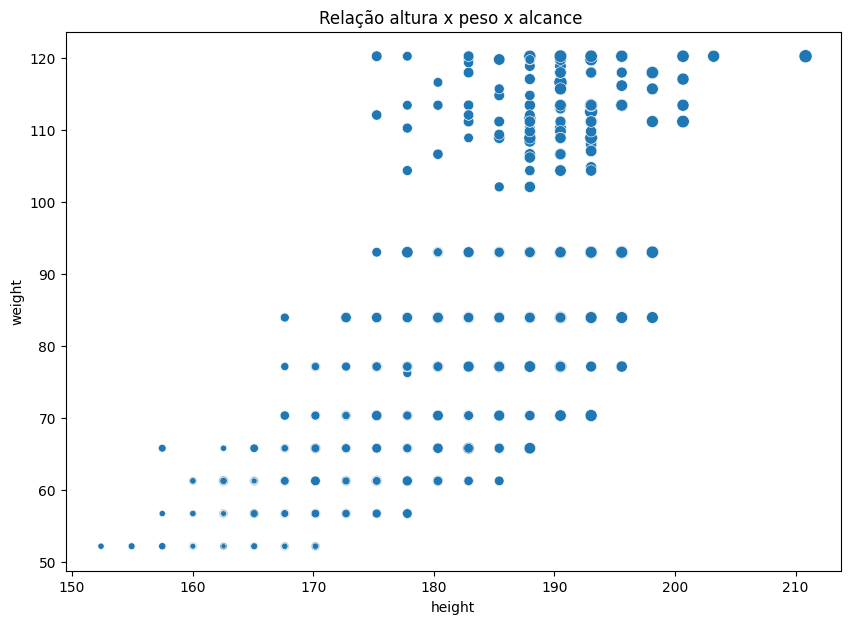

In [ ]:
# Plotando gráfico
fig = plt.figure(figsize=(10, 7))

sns.scatterplot(x="height", y="weight", s=reach_estimator["reach_size"]*2, data=reach_estimator)

plt.title("Relação altura x peso x alcance ")

plt.show()

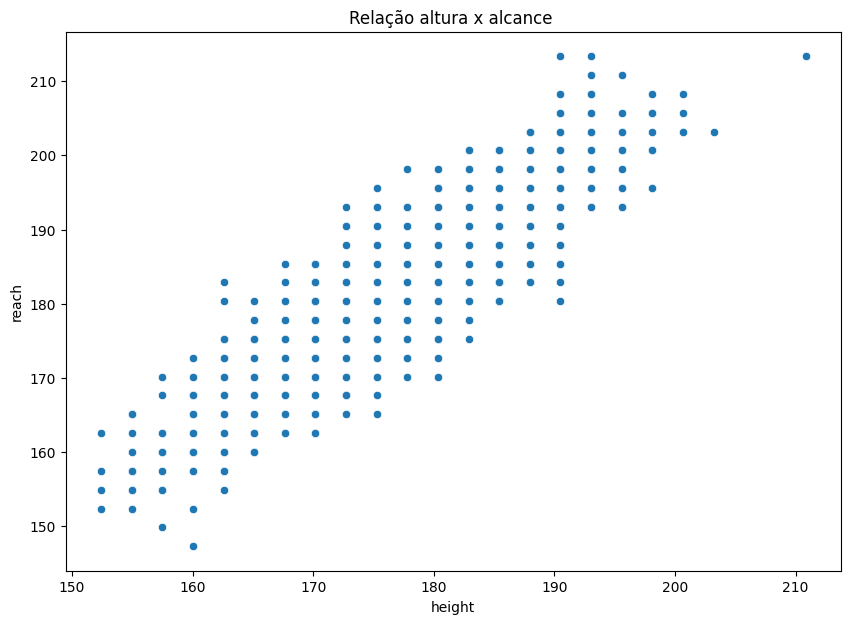

In [ ]:
# Plotando gráfico
fig = plt.figure(figsize=(10, 7))

sns.scatterplot(x="height", y="reach", data=reach_estimator)

plt.title("Relação altura x alcance ")

plt.show()

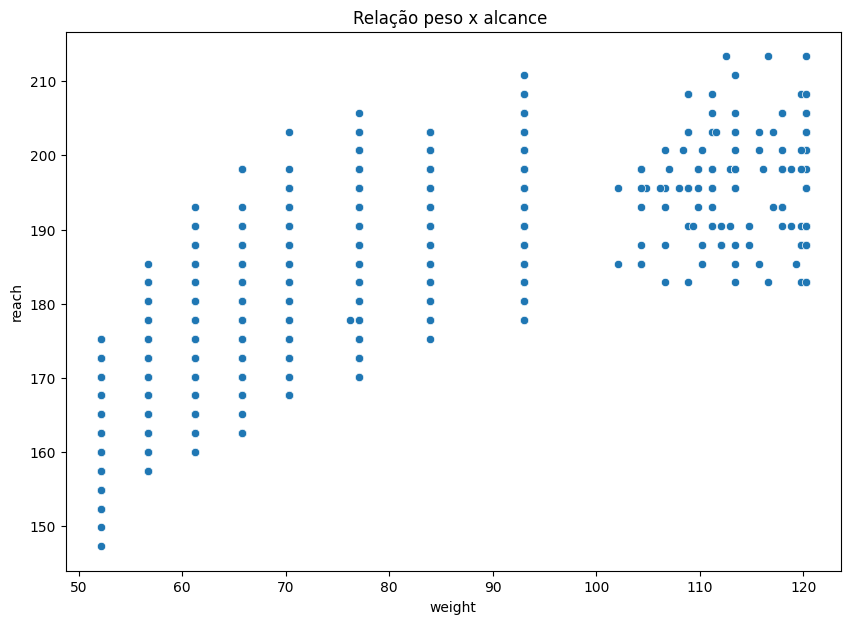

In [ ]:
# Plotando gráfico
fig = plt.figure(figsize=(10, 7))

sns.scatterplot(x="weight", y="reach", data=reach_estimator)

plt.title("Relação peso x alcance ")

plt.show()

Inicialmente, observa-se uma correlação linear positiva entre o peso, altura e alcance dos lutadores. Por isso, para os lutadores com alcance não especificado, utilizaremos um modelo básico de regressão para estimar esses valores.

In [ ]:
# Ajustando preditoras
X = reach_estimator[["height", "weight"]]
y = reach_estimator["reach"]

# Dividindo o conjunto de teste e treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# Realizando a modelagem
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Realizando predições e avaliando performance
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Erro Quadrático Médio (MSE): {mse:.2f}")

Erro Quadrático Médio (MSE): 20.67


In [ ]:
# Calculando o R^2
r2_score = model.score(X_test, y_test)
print(f"R^2: {r2_score:.2f}")

R^2: 0.80


In [ ]:
# Coeficientes de regresão
print("Coeficientes:", model.coef_)
print("Intercepto:", model.intercept_)

Coeficientes: [0.89649008 0.11005382]
Intercepto: 14.726712049417102


Agora que temos a modelagem pronta, podemos predizer os valores nulos.

A equação linear que descreve os dados é:

$$\hat{r} = 14.7267 + 0.8965*h + 0.11005w$$

no qual:

- $\hat{r}$ - estimativa do reach(alcance)
- $h$ - altura do lutador
- $w$ - peso do lutador

In [ ]:
# Realizando predições para o lutador 1
df_abordagem1.loc[df_abordagem1["reach1"].isna(), "reach1"] = 14.726712049417102 + 0.89649008 * df_abordagem1["height1"] + 0.11005382 * df_abordagem1["weight1"]

# Realizando predições para o lutador 2
df_abordagem1.loc[df_abordagem1["reach2"].isna(), "reach2"] = 14.726712049417102 + 0.89649008 * df_abordagem1["height2"] + 0.11005382 * df_abordagem1["weight2"]

# Conferindo quantidades de reachs zerados
# Lutador 1
print("Lutadores 1 com reach null")
print(df_abordagem1[df_abordagem1['reach1'].isna()].shape[0])

# Lutador 2
print("Lutadores 2 com reach null")
print(df_abordagem1[df_abordagem1['reach2'].isna()].shape[0])

Lutadores 1 com reach null
0
Lutadores 2 com reach null
0


#### ***Wins, Loses, Draws and Total Fights***

O principal desafio ao computar as vitórias, derrotas e empates de cada lutador reside na questão temporal. Analiticamente falando, não podemos levar em conta vitórias que ainda não ocorreram ao treinar o modelo com base em lutas passadas. Por exemplo, mesmo sabendo que Anderson Silva acumulou muitas vitórias e se destacou como campeão, não podemos considerar esse registro de sucessos em sua primeira luta, uma vez que este sucesso ainda não havia ocorrido.

Primeiramente iremos cálcular o histórico de lutas com base nos eventos disponiveis nesta base de dados.

In [ ]:
# Adicionando a data 
df_abordagem1 = df_abordagem1.merge(df_events[["event_id", "date"]], on="event_id", how="left")

df_abordagem1


,event_id,fight_id,weight_class,w/l,fighter1,fighter2,method,fighters1_id,fighters2_id,stance1,stance2,height1,height2,weight1,weight2,reach1,reach2,date
0,EVE0663,F066301,Women's Flyweight,draw,Alexa Grasso,Valentina Shevchenko,S-DEC,FIG1586,FIG0827,Orthodox,Southpaw,165.10,165.10,56.699,56.699,167.640000,167.640000,2023-09-16
1,EVE0663,F066302,Welterweight,win,Jack Della Maddalena,Kevin Holland,S-DEC,FIG1911,FIG0408,Switch,Orthodox,180.34,190.50,77.111,77.111,185.420000,205.740000,2023-09-16
2,EVE0663,F066303,Bantamweight,win,Raul Rosas Jr.,Terrence Mitchell,KO/TKO_Punches,FIG3312,FIG1830,Switch,Orthodox,175.26,177.80,61.235,61.235,170.180000,187.960000,2023-09-16
3,EVE0663,F066304,Lightweight,win,Daniel Zellhuber,Christos Giagos,SUB_Anaconda_Choke,FIG2320,FIG0614,Switch,Orthodox,185.42,177.80,70.307,70.307,195.580000,180.340000,2023-09-16
4,EVE0663,F066305,Featherweight,win,Kyle Nelson,Fernando Padilla,U-DEC,FIG1431,FIG1609,Switch,Orthodox,180.34,185.42,65.771,65.771,180.340000,193.040000,2023-09-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7363,EVE0001,F000111,Open Weight,win,Orlando Wiet,Robert Lucarelli,KO/TKO,FIG3607,FIG4000,Southpaw,Orthodox,177.80,187.96,77.111,111.130,182.609008,195.461269,1994-03-11
7364,EVE0001,F000112,Open Weight,win,Frank Hamaker,Thaddeus Luster,SUB_Keylock,FIG4059,FIG4006,Orthodox,Orthodox,185.42,190.50,92.986,95.254,191.187367,195.991139,1994-03-11
7365,EVE0001,F000113,Open Weight,win,Johnny Rhodes,David Levicki,KO/TKO_Punches,FIG3858,FIG3850,Orthodox,Orthodox,182.88,195.58,95.254,124.738,189.159884,203.790135,1994-03-11
7366,EVE0001,F000114,Open Weight,win,Patrick Smith,Ray Wizard,SUB_Guillotine_Choke,FIG0308,FIG4021,Orthodox,Orthodox,187.96,182.88,102.058,104.326,194.462860,190.158293,1994-03-11


In [ ]:
# Computando vitórias, derrotas, empates e no contests

def hist_cont(df):
    """
        Função que cria o dataframe com o historico de vitórias de cada lutador
    """

    # Criando dataframe copia do original 
    df_function = df.copy()

    # Criando lista com todos os lutadores
    fighters1_list = df_function["fighters1_id"].drop_duplicates().to_list()
    fighters2_list = df_function["fighters2_id"].drop_duplicates().to_list()
    fighters_list = fighters2_list

    for id in fighters1_list:
        if id not in fighters2_list:
            fighters_list.append(id)

    # Criando dataframe com o historico de luta em ordem cronologica
    df_fight_history = pd.DataFrame()

    # Loop de iteração de cada lutador
    for id in fighters_list:
        # Dataframe de processamento
        df_process = df_function.loc[(df_function["fighters1_id"] == id) | (df_function["fighters2_id"] == id), ["fighters1_id", "fighters2_id", "w/l", "date", "event_id"]]

        # Criando coluna do lutador que esta sendo computado
        df_process["fighter_id"] = id

        # Ordenando de maneira cronologica
        df_process = df_process.sort_values("date")

        # Criando colunas flag
        df_process["win_flag"] = df_process.apply(lambda x: 1 if (x["w/l"] == "win") & (x["fighters1_id"] == x["fighter_id"]) else 0, axis=1)
        df_process["lose_flag"] = df_process.apply(lambda x: 1 if (x["w/l"] == "win") & (x["fighters1_id"] != x["fighter_id"]) else 0, axis=1)
        df_process["draw_flag"] = df_process.apply(lambda x: 1 if x["w/l"] == "draw" else 0, axis=1)
        df_process["nc_flag"] = df_process.apply(lambda x: 1 if x["w/l"] == "nc" else 0, axis=1)

        # Criando historico cumulativo
        df_process["wins"] = df_process["win_flag"].shift(1).cumsum().fillna(0)
        df_process["losses"] = df_process["lose_flag"].shift(1).cumsum().fillna(0)
        df_process["draws"] = df_process["draw_flag"].shift(1).cumsum().fillna(0)
        df_process["ncs"] = df_process["nc_flag"].shift(1).cumsum().fillna(0)

        # Criando coluna de tempo de inatividade
        df_process["date"] = pd.to_datetime(df_process["date"])
        df_process["day_wout_fights"] = df_process["date"].shift(1) - df_process["date"]
        df_process["day_wout_fights"] = df_process["day_wout_fights"].dt.days
        df_process["day_wout_fights"] = -1*df_process["day_wout_fights"]    


        # Removendo coluna de flags
        df_process = df_process.drop(columns=["win_flag", "lose_flag", "draw_flag", "nc_flag"])


        # Realizando junção no dataframe final
        df_fight_history = pd.concat([df_fight_history, df_process], ignore_index=True)


    return df_fight_history


df_fight_history = hist_cont(df_abordagem1)

df_fight_history

,fighters1_id,fighters2_id,w/l,date,event_id,fighter_id,wins,losses,draws,ncs,day_wout_fights
0,FIG0827,FIG1298,win,2015-12-19,EVE0343,FIG0827,0.0,0.0,0.0,0.0,NaN
1,FIG0716,FIG0827,win,2016-03-05,EVE0350,FIG0827,1.0,0.0,0.0,0.0,77.0
2,FIG0827,FIG1202,win,2016-07-23,EVE0364,FIG0827,1.0,1.0,0.0,0.0,140.0
3,FIG0827,FIG1813,win,2017-01-28,EVE0386,FIG0827,2.0,1.0,0.0,0.0,189.0
4,FIG0716,FIG0827,win,2017-09-09,EVE0409,FIG0827,3.0,1.0,0.0,0.0,224.0
...,...,...,...,...,...,...,...,...,...,...,...
14731,FIG3900,FIG4009,win,1995-09-08,EVE0006,FIG3900,0.0,0.0,0.0,0.0,NaN
14732,FIG3514,FIG3753,win,1995-07-14,EVE0005,FIG3514,0.0,0.0,0.0,0.0,NaN
14733,FIG3514,FIG2547,win,1995-09-08,EVE0006,FIG3514,1.0,0.0,0.0,0.0,56.0
14734,FIG3959,FIG4045,win,1995-04-07,EVE0004,FIG3959,0.0,0.0,0.0,0.0,NaN


Agora que temos o dataframe com o historico de cada lutador, podemos realizar um merge com o df_abordagem1 e computar estes dados no dataframe final da modelagem

In [ ]:
# Criando momentaneamente a chave para o merge
df_fight_history["merge_key"] = df_fight_history["event_id"] + df_fight_history["fighter_id"]
df_abordagem1["merge1_key"] = df_abordagem1["event_id"] + df_abordagem1["fighters1_id"]
df_abordagem1["merge2_key"] = df_abordagem1["event_id"] + df_abordagem1["fighters2_id"]

# Realizando o merge para o fighter 1
df_abordagem1 = df_abordagem1.merge(df_fight_history[["merge_key", "wins"]], right_on="merge_key", left_on="merge1_key", how="left")
df_abordagem1 = df_abordagem1.rename(columns={"wins": "wins1"})
df_abordagem1 = df_abordagem1.drop(columns=["merge_key"])

df_abordagem1 = df_abordagem1.merge(df_fight_history[["merge_key", "losses"]], right_on="merge_key", left_on="merge1_key", how="left")
df_abordagem1 = df_abordagem1.rename(columns={"losses": "losses1"})
df_abordagem1 = df_abordagem1.drop(columns=["merge_key"])

df_abordagem1 = df_abordagem1.merge(df_fight_history[["merge_key", "draws"]], right_on="merge_key", left_on="merge1_key", how="left")
df_abordagem1 = df_abordagem1.rename(columns={"draws": "draws1"})
df_abordagem1 = df_abordagem1.drop(columns=["merge_key"])

df_abordagem1 = df_abordagem1.merge(df_fight_history[["merge_key", "ncs"]], right_on="merge_key", left_on="merge1_key", how="left")
df_abordagem1 = df_abordagem1.rename(columns={"ncs": "ncs1"})
df_abordagem1 = df_abordagem1.drop(columns=["merge_key"])

# Realizando o merge para o fighter 2
df_abordagem1 = df_abordagem1.merge(df_fight_history[["merge_key", "wins"]], right_on="merge_key", left_on="merge2_key", how="left")
df_abordagem1 = df_abordagem1.rename(columns={"wins": "wins2"})
df_abordagem1 = df_abordagem1.drop(columns=["merge_key"])

df_abordagem1 = df_abordagem1.merge(df_fight_history[["merge_key", "losses"]], right_on="merge_key", left_on="merge2_key", how="left")
df_abordagem1 = df_abordagem1.rename(columns={"losses": "losses2"})
df_abordagem1 = df_abordagem1.drop(columns=["merge_key"])

df_abordagem1 = df_abordagem1.merge(df_fight_history[["merge_key", "draws"]], right_on="merge_key", left_on="merge2_key", how="left")
df_abordagem1 = df_abordagem1.rename(columns={"draws": "draws2"})
df_abordagem1 = df_abordagem1.drop(columns=["merge_key"])

df_abordagem1 = df_abordagem1.merge(df_fight_history[["merge_key", "ncs"]], right_on="merge_key", left_on="merge2_key", how="left")
df_abordagem1 = df_abordagem1.rename(columns={"ncs": "ncs2"})
df_abordagem1 = df_abordagem1.drop(columns=["merge_key"])

# Removendo coluna de merge_keys

df_abordagem1 = df_abordagem1.drop(columns=["merge2_key", "merge1_key"])


df_abordagem1

,event_id,fight_id,weight_class,w/l,fighter1,fighter2,method,fighters1_id,fighters2_id,stance1,stance2,height1,height2,weight1,weight2,reach1,reach2,date,wins1,losses1,draws1,ncs1,wins2,losses2,draws2,ncs2
0,EVE0663,F066301,Women's Flyweight,draw,Alexa Grasso,Valentina Shevchenko,S-DEC,FIG1586,FIG0827,Orthodox,Southpaw,165.10,165.10,56.699,56.699,167.640000,167.64000,2023-09-16,8.0,3.0,0.0,0.0,12.0,3.0,0.0,0.0
1,EVE0663,F066302,Welterweight,win,Jack Della Maddalena,Kevin Holland,S-DEC,FIG1911,FIG0408,Switch,Orthodox,180.34,190.50,77.111,77.111,185.420000,205.74000,2023-09-16,5.0,0.0,0.0,0.0,12.0,6.0,0.0,1.0
2,EVE0663,F066303,Bantamweight,win,Raul Rosas Jr.,Terrence Mitchell,KO/TKO_Punches,FIG3312,FIG1830,Switch,Orthodox,175.26,177.80,61.235,61.235,170.180000,187.96000,2023-09-16,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,EVE0663,F066304,Lightweight,win,Daniel Zellhuber,Christos Giagos,SUB_Anaconda_Choke,FIG2320,FIG0614,Switch,Orthodox,185.42,177.80,70.307,70.307,195.580000,180.34000,2023-09-16,1.0,1.0,0.0,0.0,6.0,6.0,0.0,0.0
4,EVE0663,F066305,Featherweight,win,Kyle Nelson,Fernando Padilla,U-DEC,FIG1431,FIG1609,Switch,Orthodox,180.34,185.42,65.771,65.771,180.340000,193.04000,2023-09-16,2.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204198,EVE0001,F000115,Open Weight,win,Scott Morris,Sean Daugherty,SUB_Guillotine_Choke,FIG3880,FIG3933,Orthodox,Orthodox,177.80,182.88,95.254,79.379,184.605715,187.41278,1994-03-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204199,EVE0001,F000115,Open Weight,win,Scott Morris,Sean Daugherty,SUB_Guillotine_Choke,FIG3880,FIG3933,Orthodox,Orthodox,177.80,182.88,95.254,79.379,184.605715,187.41278,1994-03-11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
204200,EVE0001,F000115,Open Weight,win,Scott Morris,Sean Daugherty,SUB_Guillotine_Choke,FIG3880,FIG3933,Orthodox,Orthodox,177.80,182.88,95.254,79.379,184.605715,187.41278,1994-03-11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
204201,EVE0001,F000115,Open Weight,win,Scott Morris,Sean Daugherty,SUB_Guillotine_Choke,FIG3880,FIG3933,Orthodox,Orthodox,177.80,182.88,95.254,79.379,184.605715,187.41278,1994-03-11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_abordagem1

,event_id,fight_id,weight_class,w/l,fighter1,fighter2,method,fighters1_id,fighters2_id,stance1,stance2,height1,height2,weight1,weight2,reach1,reach2,date,wins1,losses1,draws1,ncs1,wins2,losses2,draws2,ncs2
0,EVE0663,F066301,Women's Flyweight,draw,Alexa Grasso,Valentina Shevchenko,S-DEC,FIG1586,FIG0827,Orthodox,Southpaw,165.10,165.10,56.699,56.699,167.640000,167.64000,2023-09-16,8.0,3.0,0.0,0.0,12.0,3.0,0.0,0.0
1,EVE0663,F066302,Welterweight,win,Jack Della Maddalena,Kevin Holland,S-DEC,FIG1911,FIG0408,Switch,Orthodox,180.34,190.50,77.111,77.111,185.420000,205.74000,2023-09-16,5.0,0.0,0.0,0.0,12.0,6.0,0.0,1.0
2,EVE0663,F066303,Bantamweight,win,Raul Rosas Jr.,Terrence Mitchell,KO/TKO_Punches,FIG3312,FIG1830,Switch,Orthodox,175.26,177.80,61.235,61.235,170.180000,187.96000,2023-09-16,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,EVE0663,F066304,Lightweight,win,Daniel Zellhuber,Christos Giagos,SUB_Anaconda_Choke,FIG2320,FIG0614,Switch,Orthodox,185.42,177.80,70.307,70.307,195.580000,180.34000,2023-09-16,1.0,1.0,0.0,0.0,6.0,6.0,0.0,0.0
4,EVE0663,F066305,Featherweight,win,Kyle Nelson,Fernando Padilla,U-DEC,FIG1431,FIG1609,Switch,Orthodox,180.34,185.42,65.771,65.771,180.340000,193.04000,2023-09-16,2.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204198,EVE0001,F000115,Open Weight,win,Scott Morris,Sean Daugherty,SUB_Guillotine_Choke,FIG3880,FIG3933,Orthodox,Orthodox,177.80,182.88,95.254,79.379,184.605715,187.41278,1994-03-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204199,EVE0001,F000115,Open Weight,win,Scott Morris,Sean Daugherty,SUB_Guillotine_Choke,FIG3880,FIG3933,Orthodox,Orthodox,177.80,182.88,95.254,79.379,184.605715,187.41278,1994-03-11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
204200,EVE0001,F000115,Open Weight,win,Scott Morris,Sean Daugherty,SUB_Guillotine_Choke,FIG3880,FIG3933,Orthodox,Orthodox,177.80,182.88,95.254,79.379,184.605715,187.41278,1994-03-11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
204201,EVE0001,F000115,Open Weight,win,Scott Morris,Sean Daugherty,SUB_Guillotine_Choke,FIG3880,FIG3933,Orthodox,Orthodox,177.80,182.88,95.254,79.379,184.605715,187.41278,1994-03-11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_fights

,event_id,weight_class,w/l,fighter1,fighter2,kd_fighter1,kd_fighter2,str_fighter1,str_fighter2,td_fighter1,td_fighter2,sub_fighter1,sub_fighter2,method,round,time,fight_id
0,EVE0663,Women's Flyweight,draw,Alexa Grasso,Valentina Shevchenko,1,0,84,80,1,4,1,1,S-DEC,5,5:00,F066301
1,EVE0663,Welterweight,win,Jack Della Maddalena,Kevin Holland,0,0,105,127,0,0,0,0,S-DEC,3,5:00,F066302
2,EVE0663,Bantamweight,win,Raul Rosas Jr.,Terrence Mitchell,1,0,18,6,0,0,0,0,KO/TKO_Punches,1,0:54,F066303
3,EVE0663,Lightweight,win,Daniel Zellhuber,Christos Giagos,0,0,36,38,0,0,1,0,SUB_Anaconda_Choke,2,3:26,F066304
4,EVE0663,Featherweight,win,Kyle Nelson,Fernando Padilla,0,0,82,72,0,0,0,0,U-DEC,3,5:00,F066305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7335,EVE0001,Open Weight,win,Orlando Wiet,Robert Lucarelli,0,0,8,2,0,1,0,1,KO/TKO,1,2:50,F000111
7336,EVE0001,Open Weight,win,Frank Hamaker,Thaddeus Luster,0,0,2,0,1,0,3,0,SUB_Keylock,1,4:52,F000112
7337,EVE0001,Open Weight,win,Johnny Rhodes,David Levicki,0,0,11,4,1,0,0,0,KO/TKO_Punches,1,12:13,F000113
7338,EVE0001,Open Weight,win,Patrick Smith,Ray Wizard,0,0,1,1,0,0,1,0,SUB_Guillotine_Choke,1,0:58,F000114


### **Abordagem 2**

O dataframe destinado à modelagem difere dos dataframes extraídos do site UFCstats via webscraping. Serão necessários ajustes e tratamentos específicos para construir o dataframe final que empregaremos na modelagem.

A principio utlizaremos como base o dataframe final abaixo:

<p align="center">
  <img src="imagens\exemplo_df_model.JPG" alt="Descrição da Imagem" width="50%"/>
</p>


### **df_fights**

A primeira etapa a ser realizada é examinar a inclusão do histórico de lutas de cada lutador. No dataframe df_fights, temos informações futuras. Quando o modelo for prever o resultado de uma luta, detalhes como knockdowns, strikes e takedowns ainda não estarão disponíveis, pois a luta ainda não ocorreu. Portanto, esses valores devem ser integrados ao histórico do respectivo lutador para que possam ser levados em conta no modelo.

Um desafio adicional ao considerar o histórico de lutas de cada lutador, como strikes, knockdowns, takedowns e submissions, é a necessidade de considerar o aspecto temporal. Isso significa que não podemos simplesmente usar o histórico atual de um lutador para suas lutas passadas que serão utilizadas para treinar o modelo. Para abordar esta questão, precisaremos construir o histórico de cada lutador levando em conta a progressão temporal.

In [ ]:
df_fights["w/l"].value_counts()

win     7207
nc        77
draw      56
Name: w/l, dtype: int64